<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 36.7MB 75kB/s 
     |████████████████████████████████| 102kB 12.9MB/s 


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [ ]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [ ]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [ ]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	train_loss: 2951.988	train_kld: 249.457	train_recon: 2702.531	train_log_var: -0.151	train_mean: 0.001	val_loss: 2402.808	val_kld: 429.411	val_recon: 1973.397	val_log_var: -0.262	val_mean: 0.003	(9.02s - 81.21s remaining)


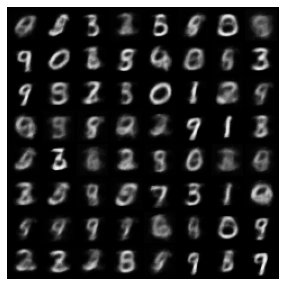

EPOCH: 2.000	train_loss: 2239.338	train_kld: 485.856	train_recon: 1753.482	train_log_var: -0.295	train_mean: 0.002	val_loss: 2109.115	val_kld: 527.339	val_recon: 1581.776	val_log_var: -0.322	val_mean: 0.006	(18.24s - 72.94s remaining)


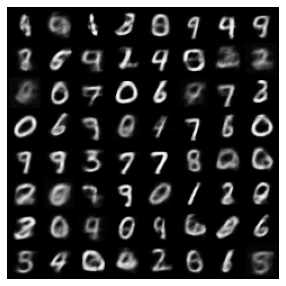

EPOCH: 3.000	train_loss: 2059.887	train_kld: 552.035	train_recon: 1507.852	train_log_var: -0.339	train_mean: 0.001	val_loss: 2001.249	val_kld: 556.408	val_recon: 1444.840	val_log_var: -0.351	val_mean: 0.001	(27.21s - 63.50s remaining)


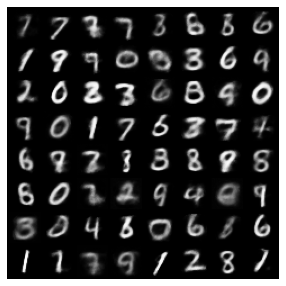

EPOCH: 4.000	train_loss: 1990.550	train_kld: 580.082	train_recon: 1410.468	train_log_var: -0.359	train_mean: 0.001	val_loss: 1946.200	val_kld: 593.726	val_recon: 1352.474	val_log_var: -0.362	val_mean: 0.003	(36.15s - 54.22s remaining)


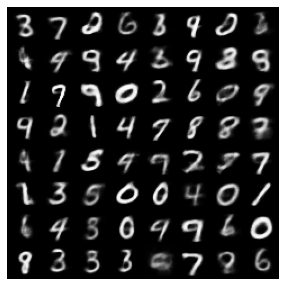

EPOCH: 5.000	train_loss: 1949.462	train_kld: 599.789	train_recon: 1349.673	train_log_var: -0.372	train_mean: 0.001	val_loss: 1918.450	val_kld: 620.096	val_recon: 1298.355	val_log_var: -0.380	val_mean: 0.000	(45.27s - 45.27s remaining)


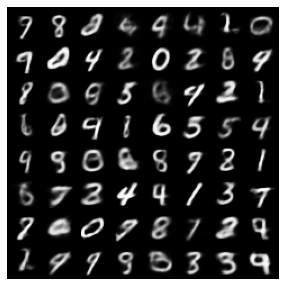

EPOCH: 6.000	train_loss: 1918.625	train_kld: 614.922	train_recon: 1303.703	train_log_var: -0.382	train_mean: 0.001	val_loss: 1894.429	val_kld: 622.975	val_recon: 1271.454	val_log_var: -0.394	val_mean: -0.001	(54.37s - 36.25s remaining)


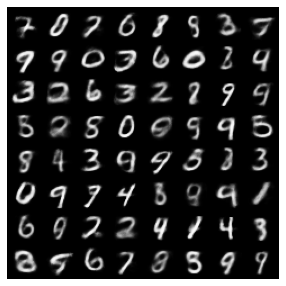

EPOCH: 7.000	train_loss: 1891.095	train_kld: 627.137	train_recon: 1263.958	train_log_var: -0.390	train_mean: 0.001	val_loss: 1861.678	val_kld: 638.065	val_recon: 1223.613	val_log_var: -0.396	val_mean: -0.005	(63.52s - 27.22s remaining)


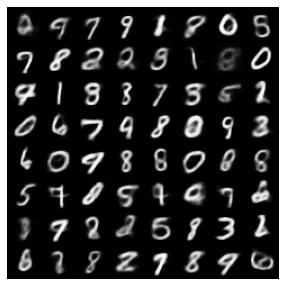

EPOCH: 8.000	train_loss: 1871.525	train_kld: 640.199	train_recon: 1231.327	train_log_var: -0.398	train_mean: 0.001	val_loss: 1854.585	val_kld: 634.219	val_recon: 1220.366	val_log_var: -0.401	val_mean: -0.001	(72.67s - 18.17s remaining)


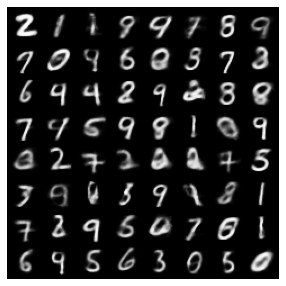

EPOCH: 9.000	train_loss: 1854.441	train_kld: 644.830	train_recon: 1209.611	train_log_var: -0.402	train_mean: 0.001	val_loss: 1842.337	val_kld: 643.656	val_recon: 1198.681	val_log_var: -0.397	val_mean: 0.004	(81.73s - 9.08s remaining)


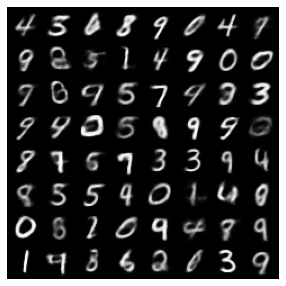

EPOCH: 10.000	train_loss: 1842.639	train_kld: 652.200	train_recon: 1190.439	train_log_var: -0.406	train_mean: 0.001	val_loss: 1832.115	val_kld: 642.405	val_recon: 1189.710	val_log_var: -0.401	val_mean: 0.007	(90.72s - 0.00s remaining)


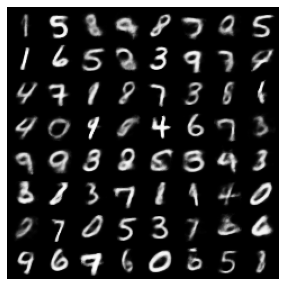

In [ ]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:00<00:00, 532.74it/s]


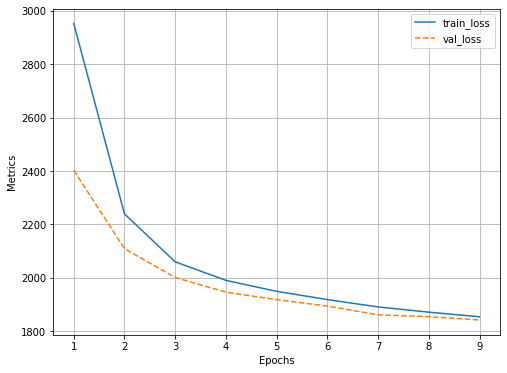

In [ ]:
log.plot_epochs(['train_loss','val_loss'])